# Recommender Systems using Average Word2vec & TF-IDF Word2vec

### Loading the dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing the dataset

In [2]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Movie Recommendation System/IMDB_Dataset.xlsx', sheet_name = 'Sheet1').drop(['Unnamed: 0'], axis = 1)
df

,Movie,ImgLink,Description
0,Project Power,https://m.media-amazon.com/images/M/MV5BYzBhOW...,When a pill that gives its users unpredictable...
1,The Tax Collector,https://m.media-amazon.com/images/M/MV5BMmFmZT...,"A ""tax collector"" working for a local crime lo..."
2,Perry Mason,https://m.media-amazon.com/images/M/MV5BMDllMW...,"In booming 1932 Los Angeles, a down-and-out de..."
3,Yellowstone,https://m.media-amazon.com/images/M/MV5BZjhkNW...,A ranching family in Montana faces off against...
4,Dark,https://m.media-amazon.com/images/M/MV5BZmY2Yz...,"A family saga with a supernatural twist, set i..."
...,...,...,...
9995,Paprika,https://m.media-amazon.com/images/M/MV5BZWMxYz...,A young country girl comes to town and works i...
9996,I'm Alan Partridge,https://m.media-amazon.com/images/M/MV5BODRmYz...,"Alan Partridge, a failed television presenter,..."
9997,Deep in the Valley,https://m.media-amazon.com/images/M/MV5BZmY4M2...,A mysterious video booth transports two friend...
9998,The Red Turtle,https://m.media-amazon.com/images/M/MV5BNGZlYz...,A man is shipwrecked on a deserted island and ...


### Text Preprocessing

Cleaning the 'Description' and storing the cleaned description in a new variable called 'Cleaned'.

In [3]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['Cleaned'] = df['Description'].apply(_removeNonAscii)
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)

---

# Recommendation Engine

We will be building two recommendation engines, one using Average Word2Vec and the other with TF-IDF Word2Vec word embeddings.

## Average Word2Vec

We will split the descriptions into words, store it in a 'corpus', and use it for training our Word2vec model.

In [4]:
# Splitting the description into words

corpus = []
for words in df['Cleaned']:
    corpus.append(words.split())

Training our corpus with Google's pre-trained Word2Vec model.

In [5]:
# Downloading the Google's pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

# Training our corpus with the model
google_model = Word2Vec(size = 300, window = 5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf = 1.0, binary = True)
google_model.train(corpus, total_examples = google_model.corpus_count, epochs = 5)

--2020-08-23 15:36:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.45|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



(0, 0)

We will create a function called vectors for generating average Word2Vec embeddings and storing them as a list called 'word_embeddings'.

In [6]:
def vectors(x):
    
    # Creating a list for storing the vectors ('Description' into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each 'Description'
    for line in df['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)

### Top 5 Recommendations using Average Word2vec

In [7]:
# Recommending the Top 5 similar movies
def recommendations(movie):
    
    # Calling the function vectors
    vectors(df)
    
    # Finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # Taking the Title and Movie Image Link and store in new dataframe called 'movies'
    movies = df[['Movie', 'ImgLink']]

    # Reverse mapping of the index
    indices = pd.Series(df.index, index = df['Movie']).drop_duplicates()
         
    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies.iloc[movie_indices]

    for index, row in recommend.iterrows():
        response = requests.get(row['ImgLink'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['Movie'])

Let's get recommendations based on the movie 'Dil Bechara'.

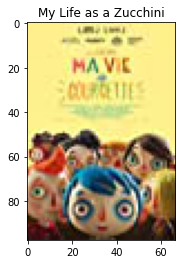

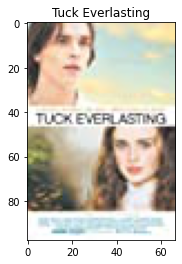

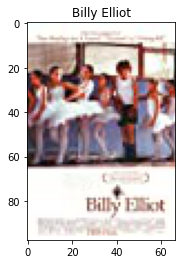

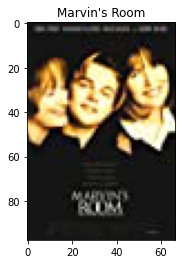

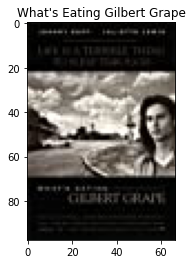

In [8]:
recommendations('Dil Bechara')

*This movie belongs to "**Romance/Drama**" genre and it recommends similar kinds of movies.*

Now, let's get a recommendation on the movie 'Avengers: Endgame'.

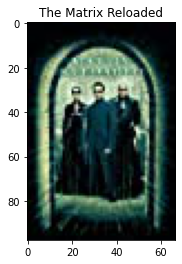

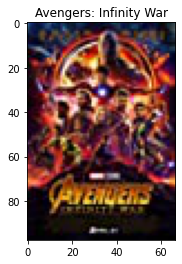

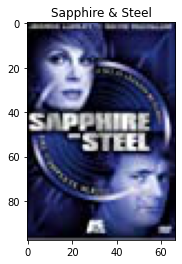

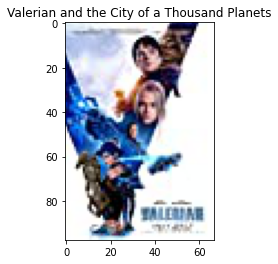

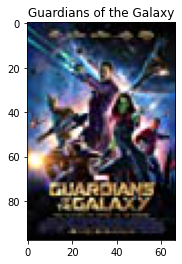

In [9]:
recommendations('Avengers: Endgame')

*This movie belongs to "**Action**" genre and it also recommends similar kinds of movies including **Guardians of the Galaxy** & **Avengers: Infinity War** which belongs to the same cinematic universe.*

---

## TF-IDF Word2Vec Model

We will use the same corpus, with the only change being in the word embeddings.

In [10]:
# Building the TF-IDF model and calculating the TF-IDF score
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 3), min_df = 5, stop_words = 'english')
tfidf.fit(df['Cleaned'])

# Getting the words from the TF-IDF model
tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

# TF-IDF words/column names
tfidf_feature = tfidf.get_feature_names()

### Building TF-IDF Word2vec Embeddings

In [11]:
# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = [] 
line = 0

# For each 'Description'
for desc in corpus:

    # Word vectors are of zero length (using 300 dimensions)
    sent_vec = np.zeros(300) 

    # Number of words with a valid vector in the 'Description'
    weight_sum =0; 

    # For each word in the 'Description'
    for word in desc: 
        if word in google_model.wv.vocab and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

### Top 5 Recommendation using TF-IDF Word2vec

In [12]:
# Recommending top 5 similar movies
def recommendations_2(movie):
    
    # Finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)
    
    # Taking the Title and Image Link and store in new data frame called movies
    movies = df[['Movie', 'ImgLink']]
    
    # Reverse mapping of the index
    indices = pd.Series(df.index, index = df['Movie']).drop_duplicates()
        
    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies.iloc[movie_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['ImgLink'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['Movie'])

Once again, let's get recommendations based on the movie 'Dil Bechara'.



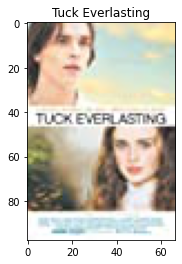

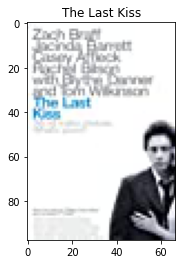

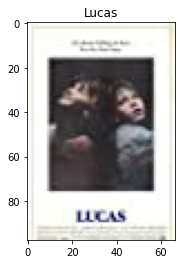

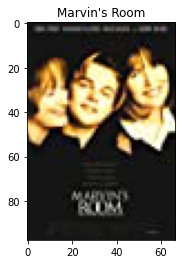

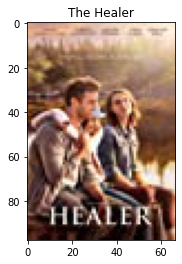

In [13]:
recommendations_2('Dil Bechara')

*The recommendations this time are a bit different & only two movies are common recommendations in both the outputs. But, the newly recommended movies also belong to a similar genre.*

Now, let's try to generate recommendations for a horror movie 'The Conjuring'.

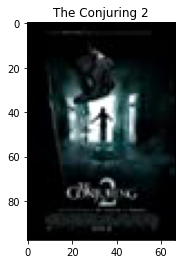

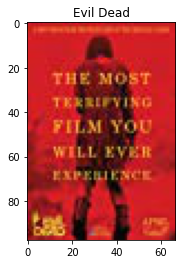

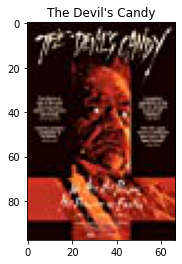

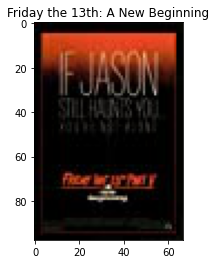

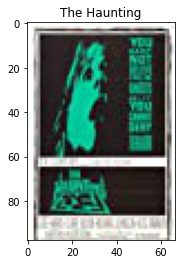

In [14]:
recommendations_2('The Conjuring')

*We can clearly see that our recommendation engine recommends other Horror movies based on the movie 'The Conjuring'.*